In [47]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import compose, ensemble, impute, linear_model, metrics, model_selection, pipeline, preprocessing, tree

In [2]:
%matplotlib inline

# Get the Data

## Fetch the data

In [6]:
import os
import tarfile
import urllib

HOUSING_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"


def fetch_data():
    os.makedirs("../data/housing/", exist_ok=True)
    urllib.request.urlretrieve(HOUSING_URL, "../data/housing/housing.tgz")
    
    with tarfile.open("../data/housing/housing.tgz") as tf:
        tf.extractall(path="../data/housing/")
        

In [7]:
fetch_data()

## Load the data

In [3]:
housing_df = pd.read_csv("../data/housing/housing.csv")

## Take a quick look at the data

In [4]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
(housing_df.loc[:, "ocean_proximity"]
           .value_counts())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


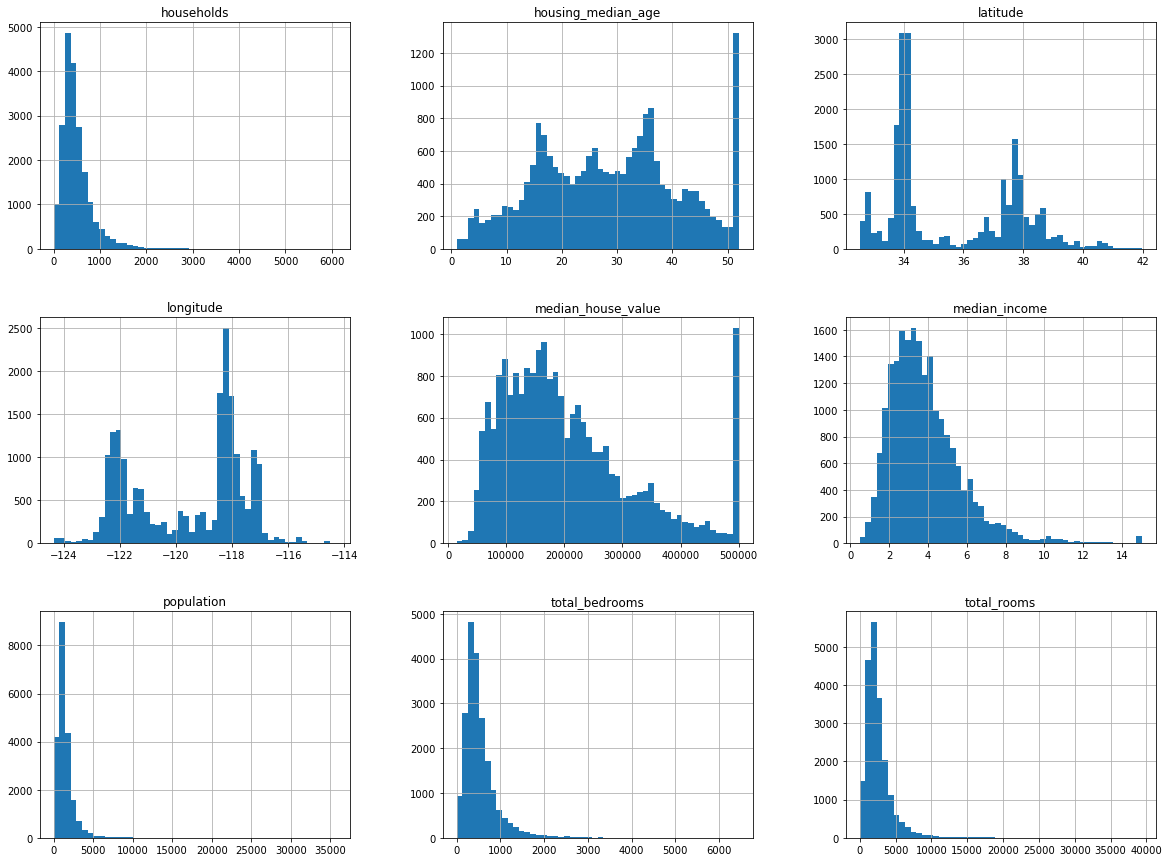

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(20,15))
housing_df.hist(bins=50, ax=ax)
plt.show()

## Train/test Split

### If you might refresh data in the future...

...then you want to use some particular hashing function to compute the hash of a unique identifier for each observation of data and include the observation in the test set if resulting hash value is less than some fixed percentage of the maximum possible hash value for your algorithm. This way even if you fetch more data, your test set will never include data that was previously included in the training data.

In [9]:
import zlib


def in_testing_data(identifier, test_size):
    _hash = zlib.crc32(bytes(identifier))
    return _hash & 0xffffffff < test_size * 2**32


def split_train_test_by_id(data, test_size, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda identifier: in_testing_data(identifier, test_size))
    return data.loc[~in_test_set], data.loc[in_test_set]

### If this is all the data you will ever have...

...then you can just set a seed for the random number generator and then randomly split the data.

In [10]:
_prng = np.random.RandomState(42)
training_data, testing_data = model_selection.train_test_split(housing_df, test_size=0.2, random_state=_prng)

In [11]:
# slighlty more sophisticated example using stratified sampling
_prng = np.random.RandomState(42)
_median_income_strata = pd.cut(housing_df.loc[:, "median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                               labels=[1, 2, 3, 4, 5])
training_data, testing_data = model_selection.train_test_split(housing_df,
                                                               test_size=0.2,
                                                               random_state=_prng,
                                                               stratify=_median_income_strata)

In [12]:
# where possible I like to write out the training and testing data sets to disk
training_data.to_csv("../data/housing/training.csv")
testing_data.to_csv("../data/housing/testing.csv")

# Explore and visualize the data to gain insights 

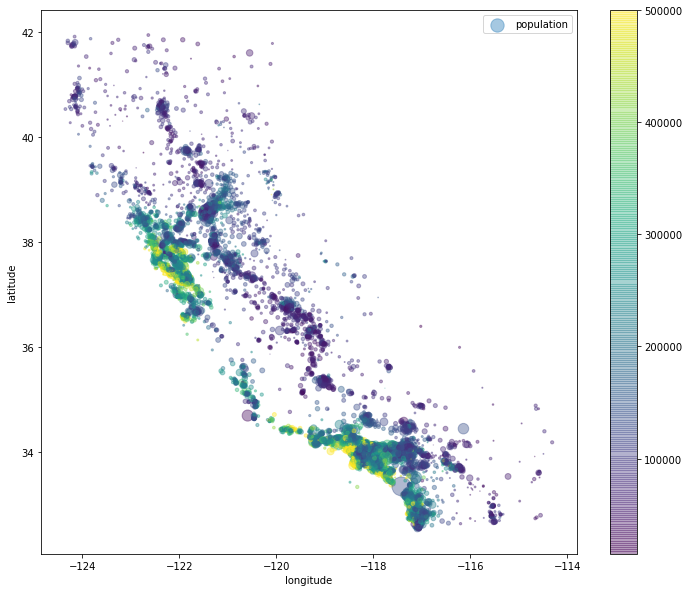

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

_size = (training_data.loc[:, "population"]
                      .div(100))
_color = training_data.loc[:, "median_house_value"]
_cmap = plt.get_cmap("viridis")

_ = (training_data.plot
                  .scatter(x="longitude", y="latitude", ax=ax, alpha=0.4, s=_size, c=_color, cmap=_cmap, label="population", colorbar=True))
_ = ax.legend()

## Looking for correlations

In [14]:
(training_data.corr()
              .loc[:, "median_house_value"]
              .sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

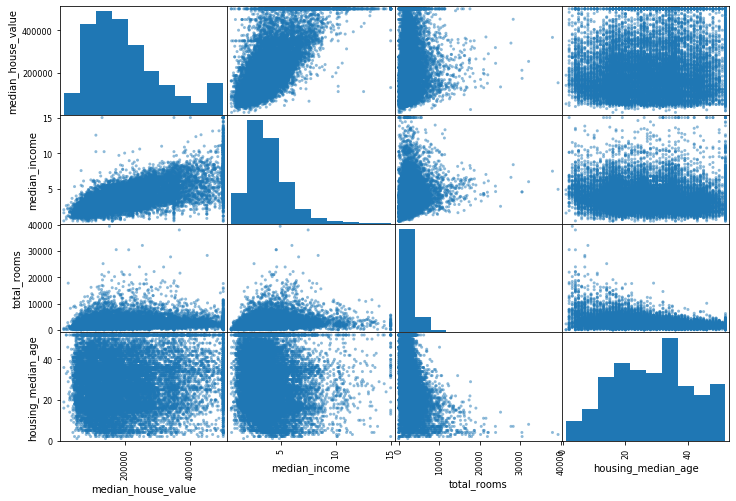

In [15]:
from pandas import plotting

attributes = ["median_house_value",
              "median_income",
              "total_rooms",
              "housing_median_age"]
_ = plotting.scatter_matrix(training_data.loc[:, attributes], figsize=(12, 8))

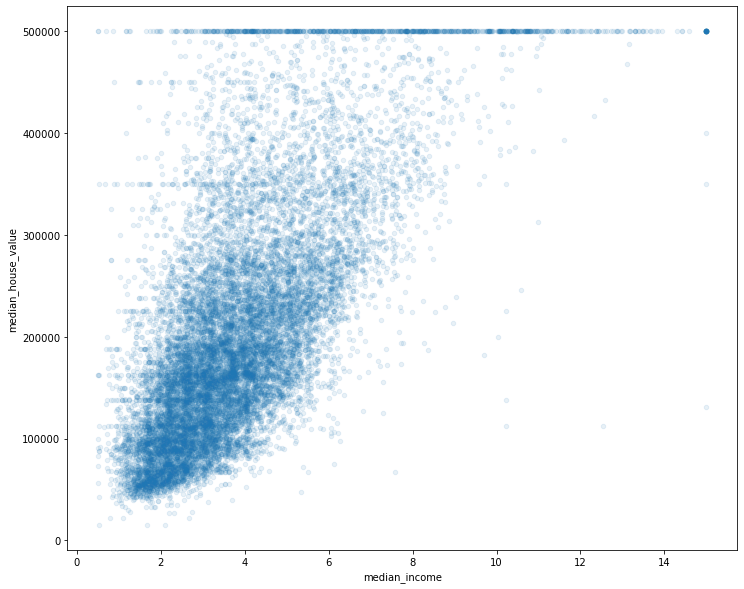

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
_ = training_data.plot.scatter(x="median_income", y="median_house_value", alpha=0.1, ax=ax)

## Experimenting with attribute combinations

In [17]:
_rooms_per_household = (training_data.loc[:, "total_rooms"]
                                     .div(training_data.loc[:, "households"]))
_bedrooms_per_room = (training_data.loc[:, "total_bedrooms"]
                                   .div(training_data.loc[:, "total_rooms"]))
_population_per_household = (training_data.loc[:, "population"]
                                          .div(training_data.loc[:, "households"]))

new_attributes = {"rooms_per_household": _rooms_per_household,
                  "bedrooms_per_room": _bedrooms_per_room, 
                  "population_per_household": _population_per_household}


In [18]:
(training_data.assign(**new_attributes)
              .corr()
              .loc[:, "median_house_value"]
              .sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare the data for machine learning algorithms

In [19]:
training_features = training_data.drop("median_house_value", axis=1, inplace=False)
training_target = training_data.loc[:, ["median_house_value"]]

In [20]:
# we will use this to impute missing values for numerical attributes
simple_imputer = impute.SimpleImputer(strategy="median")

# we will use this to encode categorical attributes
one_hot_encoder = preprocessing.OneHotEncoder()

## Custom Transformers

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin


class AttributesAdder(BaseEstimator, TransformerMixin):
    
    _total_rooms_ix = 3
    _total_bedrooms_ix = 4
    _population_ix = 5
    _households_ix = 6
    
    def __init__(self, include_bedrooms_per_room=False, include_population_per_household=False, include_rooms_per_household=False):
        self._include_bedrooms_per_room = include_bedrooms_per_room
        self._include_population_per_household = include_population_per_household
        self._include_rooms_per_household = include_rooms_per_household
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        atttributes = [X]
        if self._include_bedrooms_per_room:
            _bedrooms_per_room = X[:, [self._total_bedrooms_ix]] / X[:, [self._total_rooms_ix]]
            attributes.append(_bedrooms_per_room)
        if self._include_population_per_household:
            _population_per_household = X[:, [self._population_ix]] / X[:, [self._households_ix]]
            attributes.append(_population_per_household)
        if self._include_rooms_per_household:
            _rooms_per_household = X[:, [self._total_rooms_ix]] / X[:, [self._households_ix]]
            attributes.append(_rooms_per_household)
        return np.hstack(atttributes)


In [22]:
attributes_adder = AttributesAdder(include_bedrooms_per_room=True, include_population_per_household=True, include_rooms_per_household=True)

## Feature Scaling

In [23]:
# we will use this to make sure that all numerical features have the same scale
standard_scaler = preprocessing.StandardScaler()

## Transformation Pipelines

In [24]:
numerical_pipeline = pipeline.Pipeline(
    steps=[('imputer', impute.SimpleImputer(strategy="median")),
           ('attributes_adder', AttributesAdder(include_bedrooms_per_room=True, include_population_per_household=True, include_rooms_per_household=True)),
           ('standard_scaler', preprocessing.StandardScaler())],
)

categorical_pipeline = pipeline.Pipeline(
    steps=[("one_hot_encoder", preprocessing.OneHotEncoder())],
)

In [25]:
numerical_attributes = ['longitude',
                        'latitude',
                        'housing_median_age',
                        'total_rooms',
                        'total_bedrooms',
                        'population',
                        'households',
                        'median_income']
categorical_attributes = ["ocean_proximity"]

preprocessing_pipeline = compose.ColumnTransformer(
    transformers=[("numerical_pipeline", numerical_pipeline, numerical_attributes),
                  ("categorical_pipeline", categorical_pipeline, categorical_attributes)],
)

In [26]:
preprocessed_training_features = preprocessing_pipeline.fit_transform(training_features)

# Select and Train a Model

In [27]:
linear_regression_scores = model_selection.cross_val_score(linear_model.LinearRegression(),
                                                           X=preprocessed_training_features,
                                                           y=training_target,
                                                           cv=10,
                                                           scoring="neg_mean_squared_error",
                                                           n_jobs=10)

In [28]:
np.sqrt(-linear_regression_scores.mean())

69274.16940918249

In [29]:
_prng = np.random.RandomState(42)
decision_tree_scores = model_selection.cross_val_score(tree.DecisionTreeRegressor(random_state=_prng),
                                                       X=preprocessed_training_features,
                                                       y=training_target,
                                                       cv=10,
                                                       scoring="neg_mean_squared_error",
                                                       n_jobs=10)

In [30]:
np.sqrt(-decision_tree_scores.mean())

69448.23452521549

In [31]:
_prng = np.random.RandomState(42)
random_forest_scores = model_selection.cross_val_score(ensemble.RandomForestRegressor(n_estimators=100, random_state=_prng, n_jobs=4),
                                                       X=preprocessed_training_features,
                                                       y=training_target,
                                                       cv=10,
                                                       scoring="neg_mean_squared_error",
                                                       n_jobs=10)

In [32]:
np.sqrt(-random_forest_scores.mean())

49640.00678301197

# Fine-tune your models

## Grid Search

In [34]:
parameter_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

_prng = np.random.RandomState(42)
random_forest_regressor = ensemble.RandomForestRegressor(n_estimators=100, random_state=_prng, n_jobs=5)

grid_search_cv = model_selection.GridSearchCV(random_forest_regressor,
                                              parameter_grid,
                                              cv=5,
                                              scoring='neg_mean_squared_error',
                                              return_train_score=True,
                                              n_jobs=5,
                                              verbose=10)

grid_search_cv.fit(preprocessed_training_features, training_target)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    7.9s finished
/home/pughdr/Research/kaust-vislab/scikit-learn-tutorials/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=5,
                                             oob_score=False,
                                             random_state=RandomState(MT19937) at 0x1483AF170780,
                                             verbose=0, warm_start=False),
             iid='war

In [35]:
grid_search_cv.best_params_

{'max_features': 6, 'n_estimators': 30}

Since hyper-parameter tuning is computationally expensive we should always save our tuned model to disk so we can reload it later.

In [37]:
import time

_timestamp = time.strftime("%Y%m%d-%H%M%S")
_ = joblib.dump(grid_search_cv.best_estimator_, f"../results/models/grid-search-cv-random-forest-regressor-{_timestamp}.pkl")

In [ ]:
_ = joblib.dump

## Randomized Search

In [39]:
from scipy import stats

_param_distributions = {
    "n_estimators": stats.geom(p=0.01),
     "min_samples_split": stats.beta(a=1, b=99),
     "min_samples_leaf": stats.beta(a=1, b=999),
}

_prng = np.random.RandomState(42)
random_forest_regressor = ensemble.RandomForestRegressor(n_estimators=100, random_state=_prng, n_jobs=5)

randomized_search_cv = model_selection.RandomizedSearchCV(
    random_forest_regressor,
    param_distributions=_param_distributions,
    scoring="neg_mean_squared_error",
    random_state=_prng,
    n_iter=10,
    cv=5,
    n_jobs=5,
    verbose=10
)

randomized_search_cv.fit(preprocessed_training_features, training_target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done  47 out of  50 | elapsed:    7.3s remaining:    0.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    7.5s finished
/home/pughdr/Research/kaust-vislab/scikit-learn-tutorials/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=5,
                                                   oob_score=False,
                                                   random_state=Ran...


In [40]:
randomized_search_cv.best_params_

{'min_samples_leaf': 0.00012201597570394589,
 'min_samples_split': 0.0006038819178630597,
 'n_estimators': 40}

In [41]:
_timestamp = time.strftime("%Y%m%d-%H%M%S")
_ = joblib.dump(grid_search_cv.best_estimator_, f"../results/models/randomized-search-cv-random-forest-regressor-{_timestamp}.pkl")

## Evaluate your system on the test data

In [45]:
testing_features = testing_data.drop("median_house_value", axis=1, inplace=False)
testing_target = testing_data.loc[:, "median_house_value"]
preprocessed_testing_features = preprocessing_pipeline.fit_transform(testing_features)

In [51]:
predictions = randomized_search_cv.best_estimator_.predict(preprocessed_testing_features)
np.sqrt(metrics.mean_squared_error(testing_target, _predictions))

54320.01948347517

In [61]:
# example of computing an estimate of the confidence interval for the test set error
confidence = 0.95
squared_errors = (testing_target - predictions)** 2
_interval = (stats.t
                  .interval(confidence,
                            squared_errors.size - 1,
                            loc=squared_errors.mean(),
                            scale=stats.sem(squared_errors)))
np.sqrt(_interval)

array([52371.19133012, 56201.31094587])